<a href="https://colab.research.google.com/github/pszjmb1/0FunWithColab/blob/master/timeseriesLstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Time Series Forecasting with the Long Short-Term Memory Network in Python
by Jason Brownlee 

Based on https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ , https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/ and https://machinelearningmastery.com/time-series-data-stationary-python/

In [1]:
# Load libraries
from math import sqrt
import numpy
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller  # for testing for stationarity
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [47]:
import logging
import sys

logging.basicConfig(format='%(asctime)s - %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Time Series Forecasting!')

2018-10-27 18:36:20,000 - INFO : Time Series Forecasting!


# Download and load data
This dataset describes the monthly number of shampoo sales over a 3 year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [2]:
dataLocation = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv"
# load dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')
#The squeeze param returns a series
series = pd.read_csv(dataLocation, header=0, parse_dates=[0], index_col=0, 
                  squeeze=True, date_parser=parser)
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))
X = dataframe.values
train_size = int(len(X) * 0.66)
print(len(dataframe.values))
print(train_size)
print(len(dataframe.values)-train_size)

     t-1    t+1
0    NaN  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3
36
23
13


# Summarize and plot first few rows


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


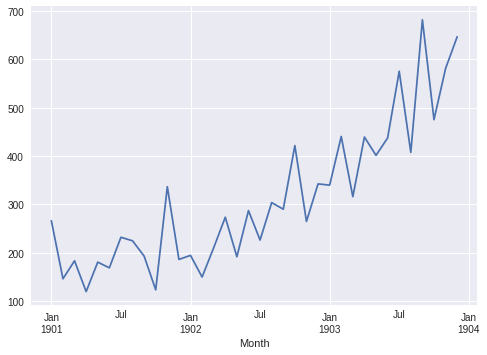

In [3]:
print(series.head())
# line plot
series.plot()
pyplot.show()

# Split data into train and test

In [0]:
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [5]:
print(len(values))
print(train_size)
print(len(test_X))

36
23
13


# Baseline Forecasting

A baseline in forecast performance provides a point of comparison.

It is a point of reference for all other modeling techniques on your problem. If a model achieves performance at or below the baseline, the technique should be fixed or abandoned.

The technique used to generate a forecast to calculate the baseline performance must be easy to implement and naive of problem-specific details.

The goal is to get a baseline performance on your time series forecast problem as quickly as possible so that you can get to work better understanding the dataset and developing more advanced models.

Three properties of a good technique for making a baseline forecast are:
 - Simple: A method that requires little or no training or intelligence.
 - Fast: A method that is fast to implement and computationally trivial to make a prediction.
 - Repeatable: A method that is deterministic, meaning that it produces an expected output given the same input.

## Persistence Forecast
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.

The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).
- This satisfies the three above conditions for a baseline forecast

We can implement this by taking the last observation from the training data and history accumulated by walk-forward validation and using that to predict the current time step.

Persistence Algorithm
1. Transform the univariate dataset into a supervised learning problem.
2. Establish the train and test datasets for the test harness.
3. Define the persistence model.
4. Make a forecast and establish a baseline performance.
5. Review the complete example and plot the output.

### Algorithm

In [0]:
def model_persistence(x):
	return x

## Baseline performance on test set

### Generate predictions from model

In [0]:
predictions_Base = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions_Base.append(yhat)

### Assess the quality of the forecast algorithm

In [8]:
test_score = mean_squared_error(test_y, predictions_Base)
rmse = sqrt(test_score)
print('Test MSE: %.3f' % test_score)
print('Test RMSE: %.3f' % rmse)

Test MSE: 17730.518
Test RMSE: 133.156


RMSE of about 133 monthly shampoo sales for the forecasts on the test dataset.

#### Plot of observed vs naive forecast

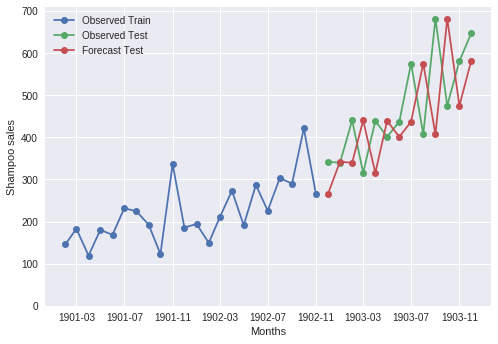

In [9]:
trainMonths, testMonths = series.keys()[1:train_size],series.keys()[train_size:]
pyplot.plot(trainMonths, train_y, 'o-', label='Observed Train',)
pyplot.plot(series.keys()[1:],[None for i in train_y] + [x for x in test_y], 'o-', label='Observed Test')
pyplot.plot(series.keys()[1:],[None for i in train_y] + [x for x in predictions_Base], 'o-', label='Forecast Test')
pyplot.xlabel('Months')
pyplot.ylabel('Shampoo sales')
pyplot.legend()
pyplot.ylim(ymin=0)
pyplot.show()

Plot of the training observed dataset then a comparison of the observed test values with the forecast ones.

# LTSM Model Forecasting

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

## Data prep
1. Transform the time series into a supervised learning problem
2. Transform the time series data so that it is stationary.
3. Transform the observations to have a specific scale.

### 1. Transform Time Series to Supervised Learning
The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

We can achieve this using the shift() function in Pandas that will push all values in a series down by a specified number places. We require a shift of 1 place, which will become the input variables. The time series as it stands will be the output variables.

We can then concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN (not a number) value will be used in this position. We will replace these NaN values with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero sales on this dataset has not been observed.

The code below defines a helper function to do this called timeseries_to_supervised(). It takes a NumPy array of the raw time series data and a lag or number of shifted series to create and use as inputs.

In [0]:
def timeseries_to_supervised(data, lag=1):
  """
  Frame a time series as a supervised learning dataset.
  Arguments:
    data: Sequence of observations as a list or NumPy array.
    lag: Number of lag observations as input (X).
  Returns:
    Pandas DataFrame of series framed for supervised learning.
  """
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df.fillna(0, inplace=True)
  return df

In [11]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      1      0      1
0    0.0    0.0    0.0  266.0
1    0.0  266.0  266.0  145.9
2  266.0  145.9  145.9  183.1
3  145.9  183.1  183.1  119.3
4  183.1  119.3  119.3  180.3


### 2. Transform Time Series to Stationary

The Shampoo Sales dataset is not stationary; there is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.

Stationary data is easier to model and will very likely result in more skillful forecasts.

#### Double-check stationarity
Look at the mean and variance for data that conforms to a Gaussian distribution. Also eyeball a histogram of our observations.

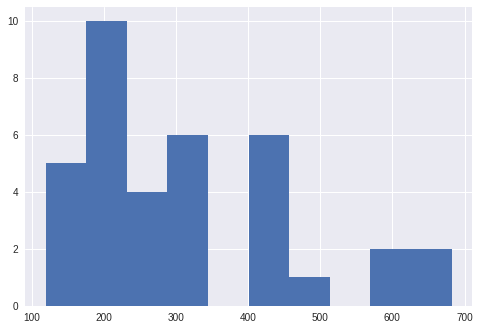

In [12]:
series.hist()
pyplot.show()

The distribution of values does not look like a Gaussian, therefore the mean and variance values are less meaningful, however, let's review them

In [13]:
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=nan, mean2=411.697222
variance1=nan, variance2=15136.461937


#### Augmented Dickey-Fuller 
Test to confirm the hypothesis that the time series is non-stationary

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [14]:
result = adfuller(series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of 3 is greater than the value of -2.6 at 10%.

This suggests that we should fail to reject the null hypothesis. 
If H0 failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

#### Remove Trends
The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

"Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality." — Page 215, Forecasting: principles and practice

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get finer grained control and write our own function to do this, which is preferred for its flexibility in this case.

In [0]:
def difference(dataset, interval=1):  
  """
	Create a differenced series. Observation from the previous time step (t-1) is 
  subtracted from the current observation (t). 
  Note that the first observation in the series is skipped as there is no prior 
  observation with which to calculate a differenced value.
	Arguments:
		dataset: Sequence of observations as a list or NumPy array.
		interval: Number of observations to consider
	Returns:
		Pandas Series of changes to the observations from one time step to the next
	"""
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

In [0]:
def inverse_difference(history, yhat, interval=1):
  """
	Invert differenced value
  Takes forecasts made on the differenced series back into their original scale.
	Arguments:
		history: Sequence of observations as a list or NumPy array.
    yhat: Output of the difference function
		interval: Number of observations to consider
	Returns:
		Pandas Series of forecasts on original scale
	"""
  return yhat + history[-interval]

In [17]:
print(series.head())
# Test the functions
differenced = difference(series, 1)    # transform to stationary
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


### 3. Transform Time Series to Scale

LSTMs expect data to be within the scale of the activation function used by the network (like other neural networks).

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

To make the experiment fair, the scaling coefficients (min and max) values must be calculated on the training dataset and applied to scale the test dataset and any forecasts. This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. Like other scikit-learn transform classes, it requires data provided in a matrix format with rows and columns. Therefore, we must reshape our NumPy arrays before transforming, and invert the scale on forecasts to return the values back to the original scale so that the results can be interpreted and a comparable error score can be calculated.

In [0]:
def scale(train, test):
	"""
	Scale train and test data to [-1, 1]
	Arguments:
		train: Train series
		test: Test series
	Returns:
		scaler, train_scaled, test_scaled
	"""
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
def invert_scale(scaler, X, value):
	"""
	Inverse scaling for a forecasted value
	Arguments:
		scaler: The scaler from the scale function output
		value: Scled series
	Returns:
		Numpy array of predictions at original scale
	"""
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [19]:
print(series.head())
# transform scale
X2 = series.values.reshape(len(series.values), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X2)
scaled_X = scaler.transform(X2)
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


## LSTM Model

In Keras, long-term memory is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].
- Samples: These are independent observations from the domain, typically rows of data.
- Time steps: These are separate time steps of a given variable for a given observation.
- Features: These are separate measures observed at the time of observation.

We have some flexibility in how the Shampoo Sales dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format.

The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.

The network requires a single neuron in the output layer with a linear activation to predict the number of shampoo sales at the next time step.

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano.

In compiling the network, we must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.

Once the network is compiled, it can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

Also by default, the network reports a lot of debug information about the learning progress and skill of the model at the end of each epoch. We can disable this by setting the “verbose” argument to the level of “0“.

We can then reset the internal state at the end of the training epoch, ready for the next training iteration.

In [0]:
def fit_lstm(train, batch_size=1, nb_epoch=1500, neurons=1):
  """
  Trains and returns an LSTM model.   
  Arguments:
    train: training dataset in a supervised learning format
    batch_size: Int, often much smaller than the total number of samples. 
                It, along with the number of epochs, defines how quickly the 
                network learns the data (how often the weights are updated).
    nb_epoch:   Int, number of epochs
    neurons:    Int, number of neurons (number of memory units or blocks). 
                A number between 1 and 5 is often sufficient.
  Returns: Keras LSTM model
  """
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  logging.info("Compiling LSTM...")
  model.compile(loss='mean_squared_error', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
    if i%250 == 0:
      logging.info("Complete fit %d of %d" % (i, nb_epoch))
  return model

In [0]:
# transform data to be stationary
raw_values = series.values
train_size = int(len(raw_values) * 0.66)
diff_values = difference(raw_values)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:train_size], supervised_values[train_size:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## LSTM performance on test set

Once the LSTM model is fit to the training data, it can be used to make forecasts.

Again, we have some flexibility. We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the fixed approach), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the dynamic approach).

In this tutorial, we will go with the fixed approach for its simplicity, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the predict() function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

In [0]:
def forecast_lstm(model, batch_size, X):
  """
  Forecasts from an LSTM model using fixed approach
  Fixed means that the model is fit once on all of the training data, 
  then predict each new time step one at a time from the test data
  Arguments:
    model: a fit model
    batch_size: Int, value as per fit_lstm (e.g. 1)
    X:   a row from the test data
  Returns: the prediction as a single floating point value
  """
  X = X.reshape(1, 1, len(X))
  yhat = model.predict(X, batch_size=batch_size)
  return yhat[0,0]

### Generate predictions from model

In [54]:
# walk-forward validation on the test data
# repeat the experiment from the previous section multiple times, 
# then take the average RMSE as an indication of how well the configuration 
# would be expected to perform on unseen data on average.
repeats = 5
error_scores = list()
for r in range(repeats): 
  # fit the model
  logging.info("Fitting LSTM %d..." % (r))
  lstm_model = fit_lstm(train_scaled)
  # forecast the entire training dataset to build up state for forecasting
  train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
  lstm_model.predict(train_reshaped, batch_size=1)
  logging.info("Making predictions...")
  predictions_lstm = list()
  for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm.append(yhat)
    expected = raw_values[len(train) + i + 1]
    logging.info('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
	# report performance
  rmse = sqrt(mean_squared_error(raw_values[train_size+1:], predictions_lstm))
  logging.info('%d) Test RMSE: %.3f' % (r+1, rmse))
  error_scores.append(rmse)

2018-10-27 18:40:55,712 - INFO : Fitting LSTM...
2018-10-27 18:40:55,937 - INFO : Compiling LSTM...
2018-10-27 18:41:00,392 - INFO : Complete fit 0 of 1500
2018-10-27 18:41:12,478 - INFO : Complete fit 250 of 1500
2018-10-27 18:41:24,847 - INFO : Complete fit 500 of 1500
2018-10-27 18:41:37,231 - INFO : Complete fit 750 of 1500
2018-10-27 18:41:49,418 - INFO : Complete fit 1000 of 1500
2018-10-27 18:42:01,844 - INFO : Complete fit 1250 of 1500
2018-10-27 18:42:14,704 - INFO : Making predictions...
2018-10-27 18:42:14,706 - INFO : Month=1, Predicted=331.141332, Expected=339.700000
2018-10-27 18:42:14,713 - INFO : Month=2, Predicted=343.871873, Expected=440.400000
2018-10-27 18:42:14,717 - INFO : Month=3, Predicted=352.454579, Expected=315.900000
2018-10-27 18:42:14,722 - INFO : Month=4, Predicted=377.186237, Expected=439.300000
2018-10-27 18:42:14,729 - INFO : Month=5, Predicted=392.675337, Expected=401.300000
2018-10-27 18:42:14,733 - INFO : Month=6, Predicted=453.049958, Expected=437.

### Assess the quality of the LSTM model

In [56]:
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())

             rmse
count    5.000000
mean    95.531946
std      6.382352
min     87.015864
25%     93.411614
50%     94.247584
75%     98.921719
max    104.062950


#### Plot of observed vs LSTM forecast

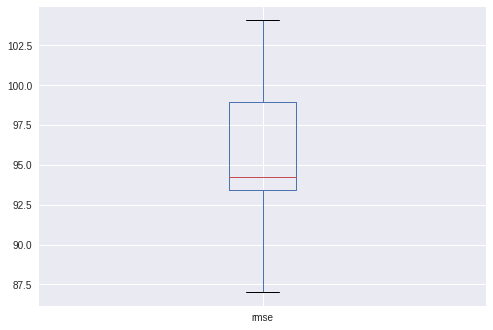

In [57]:
results.boxplot()
pyplot.show()

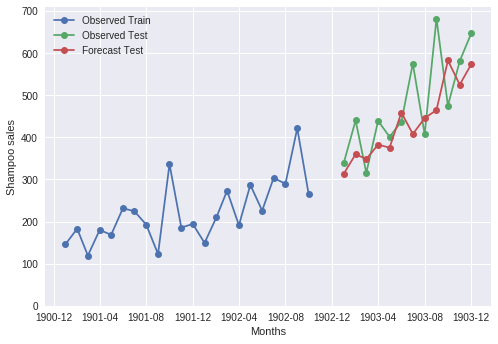

In [25]:
trainMonths, testMonths = series.keys()[0:train_size-1],series.keys()[train_size+1:]
pyplot.plot(trainMonths, train_y, 'o-', label='Observed Train',)
pyplot.plot(testMonths,raw_values[train_size+1:], 'o-', label='Observed Test')
pyplot.plot(testMonths,predictions_lstm, 'o-', label='Forecast Test')
pyplot.xlabel('Months')
pyplot.ylabel('Shampoo sales')
pyplot.legend()
pyplot.ylim(ymin=0)
pyplot.show()

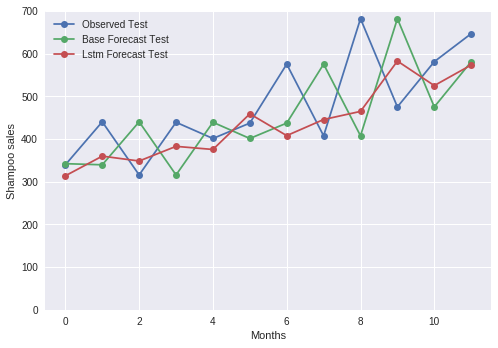

In [26]:
pyplot.plot(raw_values[train_size+1:], 'o-', label='Observed Test')
pyplot.plot(predictions_Base[1:], 'o-', label='Base Forecast Test')
pyplot.plot(predictions_lstm, 'o-', label='Lstm Forecast Test')
pyplot.xlabel('Months')
pyplot.ylabel('Shampoo sales')
pyplot.legend()
pyplot.ylim(ymin=0)
pyplot.show()